In [ ]:
!pip install dowhy
import dowhy
import pandas as pd

     |████████████████████████████████| 123 kB 4.8 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/zhw005/dowhy-datasets/main/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Attribute Information

* Age: age of the patient [years]

* Sex: sex of the patient [M: Male, F: Female]

* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

* RestingBP: resting blood pressure [mm Hg]

* Cholesterol: serum cholesterol [mm/dl]

* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

* Oldpeak: oldpeak = ST [Numeric value measured in depression]

* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

* HeartDisease: output class [1: heart disease, 0: Normal]

In [ ]:
# data cleaning
data.loc[data.ExerciseAngina == 'Y', 'ExerciseAngina'] = 1
data.loc[data.ExerciseAngina == 'N', 'ExerciseAngina'] = 0

In [ ]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,0,0.0,Up,0


In [ ]:
data.groupby(['ExerciseAngina'])['HeartDisease'].mean()

ExerciseAngina
0    0.351005
1    0.851752
Name: HeartDisease, dtype: float64

In [ ]:
!apt-get install -y graphviz-dev
!sudo pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubun

In [ ]:
import pygraphviz

In [ ]:
# 1. Model
model= dowhy.CausalModel(
        data = data,
        treatment='ExerciseAngina',
        outcome='HeartDisease',
        common_causes = 'Age')
model.view_model()

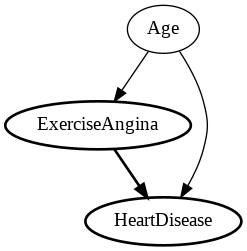

In [ ]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [ ]:
# 2. Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                       
─────────────────(Expectation(HeartDisease|Age))
d[ExerciseAngina]                               
Estimand assumption 1, Unconfoundedness: If U→{ExerciseAngina} and U→HeartDisease then P(HeartDisease|ExerciseAngina,Age,U) = P(HeartDisease|ExerciseAngina,Age)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [ ]:
# 3. Estimate
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                       
─────────────────(Expectation(HeartDisease|Age))
d[ExerciseAngina]                               
Estimand assumption 1, Unconfoundedness: If U→{ExerciseAngina} and U→HeartDisease then P(HeartDisease|ExerciseAngina,Age,U) = P(HeartDisease|ExerciseAngina,Age)

## Realized estimand
b: HeartDisease~ExerciseAngina+Age
Target units: ate

## Estimate
Mean value: 0.4605341547033778



Having exercise-induced angina increases the chance of getting heart disease.

In [ ]:
# 4. Refute

# Radom Common Cause:- Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. 
# If our assumption was originally correct then the causal estimate shouldn’t change by much.
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

# Placebo Treatment Refuter:- Randomly assigns any covariate as a treatment and re-runs the analysis. 
# If our assumptions were correct then this newly found out estimate should go to 0.
#refute2_results=model.refute_estimate(identified_estimand, estimate, 
#                                      method_name="placebo_treatment_refuter")
#print(refute2_results)

# Data Subset Refuter:- Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. 
# If our assumptions were correct there shouldn’t be much variation.
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Add a Random Common Cause
Estimated effect:0.4605341547033778
New effect:0.45998156388986616

Refute: Use a subset of data
Estimated effect:0.4605341547033778
New effect:0.46111266259318934
p value:0.44



We can see that our estimate passes all three refutation tests. This does not prove its correctness, but it increases confidence in the estimate.